In [ ]:
%%capture
!pip install transformers

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import classification_report


In [ ]:
!git clone https://github.com/drmuskangarg/CAMS.git

fatal: destination path 'CAMS' already exists and is not an empty directory.


In [ ]:
BATCH = 4

In [ ]:
a_ = f'./CAMS/CAMS/data/IntentSDCNL_Testing.csv'
b_ = f'./CAMS/CAMS/data/IntentSDCNL_Training.csv'
df = pd.read_csv(b_, usecols=['selftext', 'ANNOTATIONS']).rename(columns={'selftext': 'text', 'ANNOTATIONS': 'category'})
df_test = pd.read_csv(a_, usecols=['selftext', 'ANNOTATIONS']).rename(columns={'selftext': 'text', 'ANNOTATIONS': 'category'})
df.head()

,text,category
0,Hi I don't really know how to phrase this situ...,5.0
1,i have been so depressed these past couple wee...,1.0
2,Hi..I don't know where else to go. I am devast...,5.0
3,"The shit like â€œit will get better, everyone ...",0.0
4,I wish I was prettier. I wish I didn't feel li...,1.0


In [ ]:
df = df.dropna().reset_index(drop=True)

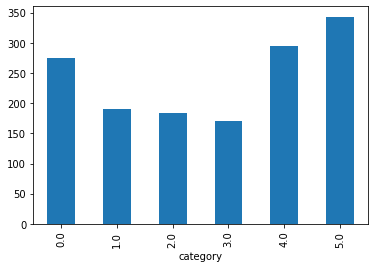

In [ ]:
df.groupby(['category']).size().plot.bar()

In [ ]:
df['category'].index[df['category'].apply(np.isnan)]

Int64Index([], dtype='int64')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {0.0:0,
          1.0:1,
          2.0:2,
          3.0:3,
          4.0:4,
          5.0:5
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
  
            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            final_out = []
            final_lab = []
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    output = output.argmax(dim=1)
                    output = output.cpu().detach().numpy()
                    val_label = val_label.cpu().detach().numpy()
                    final_out.extend(list(output))
                    final_lab.extend(list(val_label))
                    # print(output.shape)
                    # print(val_label.shape)
 

            print (classification_report(final_lab, final_out))
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    truth = []
    final_out = []
    final_lab = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              output = output.argmax(dim=1)
              output = output.cpu().detach().numpy()
              test_label = test_label.cpu().detach().numpy()
              final_out.extend(list(output))
              final_lab.extend(list(test_label))

    print (classification_report(final_lab, final_out))
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
len(df)

1457

In [ ]:
np.random.seed(112)
df_train, df_val = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df))])

print(len(df_train),len(df_val), len(df_test))

1165 292 370


In [ ]:
EPOCHS = 6
model = BertClassifier()
LR = 5e-5
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 292/292 [01:49<00:00,  2.67it/s]


              precision    recall  f1-score   support

           0       0.30      0.45      0.36        58
           1       0.25      0.03      0.05        35
           2       0.00      0.00      0.00        34
           3       0.06      0.15      0.08        27
           4       0.28      0.42      0.34        73
           5       0.24      0.08      0.12        65

    accuracy                           0.23       292
   macro avg       0.19      0.19      0.16       292
weighted avg       0.22      0.23      0.20       292

Epochs: 1 | Train Loss:  0.454 | Train Accuracy:  0.193 | Val Loss:  0.446 | Val Accuracy:  0.229


100%|██████████| 292/292 [01:46<00:00,  2.75it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.19      0.86      0.32        58
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        27
           4       0.50      0.01      0.03        73
           5       0.25      0.11      0.15        65

    accuracy                           0.20       292
   macro avg       0.16      0.16      0.08       292
weighted avg       0.22      0.20      0.10       292

Epochs: 2 | Train Loss:  0.448 | Train Accuracy:  0.167 | Val Loss:  0.448 | Val Accuracy:  0.199


100%|██████████| 292/292 [01:46<00:00,  2.74it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.19      0.33      0.24        58
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        34
           3       0.33      0.04      0.07        27
           4       0.43      0.04      0.07        73
           5       0.21      0.57      0.30        65

    accuracy                           0.21       292
   macro avg       0.19      0.16      0.11       292
weighted avg       0.22      0.21      0.14       292

Epochs: 3 | Train Loss:  0.450 | Train Accuracy:  0.206 | Val Loss:  0.449 | Val Accuracy:  0.205


100%|██████████| 292/292 [01:45<00:00,  2.76it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.19      0.86      0.31        58
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        73
           5       0.27      0.06      0.10        65

    accuracy                           0.18       292
   macro avg       0.08      0.15      0.07       292
weighted avg       0.10      0.18      0.08       292

Epochs: 4 | Train Loss:  0.450 | Train Accuracy:  0.192 | Val Loss:  0.449 | Val Accuracy:  0.185


100%|██████████| 292/292 [01:45<00:00,  2.78it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.20      0.79      0.33        58
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        34
           3       0.09      0.11      0.10        27
           4       0.33      0.01      0.03        73
           5       0.24      0.11      0.15        65

    accuracy                           0.20       292
   macro avg       0.14      0.17      0.10       292
weighted avg       0.19      0.20      0.11       292

Epochs: 5 | Train Loss:  0.449 | Train Accuracy:  0.184 | Val Loss:  0.449 | Val Accuracy:  0.195


100%|██████████| 292/292 [01:44<00:00,  2.78it/s]


              precision    recall  f1-score   support

           0       0.20      0.90      0.33        58
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        73
           5       0.23      0.11      0.15        65

    accuracy                           0.20       292
   macro avg       0.07      0.17      0.08       292
weighted avg       0.09      0.20      0.10       292

Epochs: 6 | Train Loss:  0.450 | Train Accuracy:  0.192 | Val Loss:  0.448 | Val Accuracy:  0.202


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluate(model, df_test)

CAMS to CAMS-HiEn


In [ ]:
from transformers import MBartForConditionalGeneration, MBartTokenizer

tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-en-hi", src_lang="en_XX", tgt_lang="hi_IN")
example_english_phrase = "UN Chief Says There Is No Military Solution in Syria"
expected_translation_romanian = "Şeful ONU declară că nu există o soluţie militară în Siria"

inputs = tokenizer([example_english_phrase, example_english_phrase], text_target=[expected_translation_romanian, expected_translation_romanian], return_tensors="pt")

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-en-ro")
# forward pass
model(**inputs)

Indic BERT Classification